In [1]:
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

from typing import List
import pickle
from lightkurve.correctors import DesignMatrix

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%matplotlib notebook

In [11]:
bss_candidates: pd.DataFrame = pd.read_csv('data/NGC 188/NGC 188_bss.csv')
literature: pd.DataFrame = pd.read_csv(f'data/NGC 188/NGC 188_found.csv')

In [12]:
bss_candidates = pd.merge(left=bss_candidates, right=literature[['EDR3 id', 'TIC']],
                                 left_on='source_id', right_on='EDR3 id', how='inner')

In [13]:
bss_candidates.phot_variable_flag.value_counts()

NOT_AVAILABLE    16
VARIABLE          1
Name: phot_variable_flag, dtype: int64

In [14]:
variable_bss = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

In [15]:
variable_bss.TIC

15    461601525.0
Name: TIC, dtype: float64

# Lightcurve

In [16]:
from lightkurve.correctors import load_tess_cbvs, load_kepler_cbvs
import numpy as np

In [17]:
ts1 = lk.search_tesscut('TIC 461601525')

In [18]:
ts1

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,TESScut,1426,TIC 461601525,0.0
1,TESS Sector 19,2019,TESScut,1426,TIC 461601525,0.0
2,TESS Sector 20,2019,TESScut,1426,TIC 461601525,0.0
3,TESS Sector 25,2020,TESScut,1426,TIC 461601525,0.0
4,TESS Sector 26,2020,TESScut,1426,TIC 461601525,0.0
5,TESS Sector 40,2021,TESScut,475,TIC 461601525,0.0
6,TESS Sector 52,2022,TESScut,475,TIC 461601525,0.0
7,TESS Sector 53,2022,TESScut,475,TIC 461601525,0.0


<IPython.core.display.Javascript object>


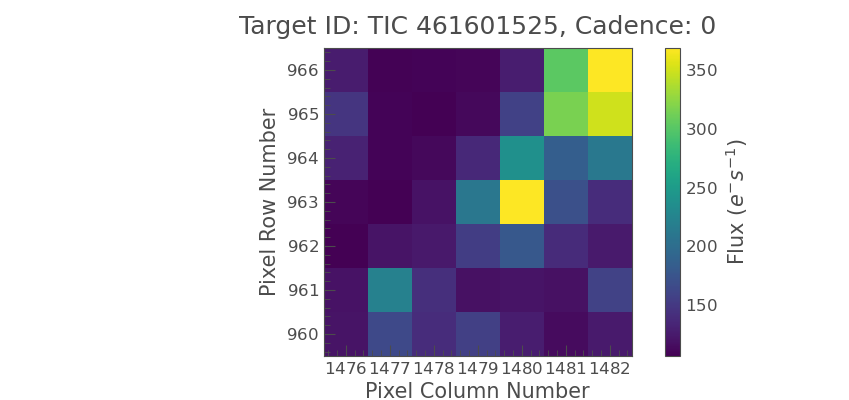

<AxesSubplot:title={'center':'Target ID: TIC 461601525, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

In [19]:
tpf = ts1[6].download(cutout_size=7)
tpf.plot()

In [20]:
aper = tpf.create_threshold_mask()

<IPython.core.display.Javascript object>


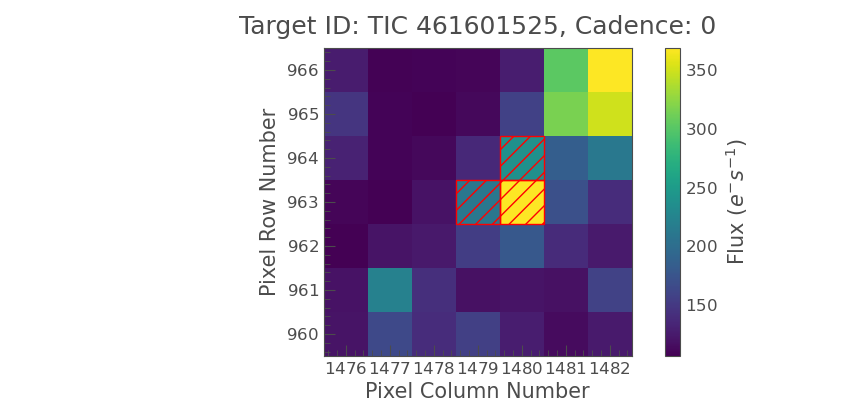

In [21]:
tpf.plot(aperture_mask=aper);

In [22]:
regressors = tpf.flux[:, ~aper]

In [23]:
regressors.shape

(3343, 46)

<IPython.core.display.Javascript object>


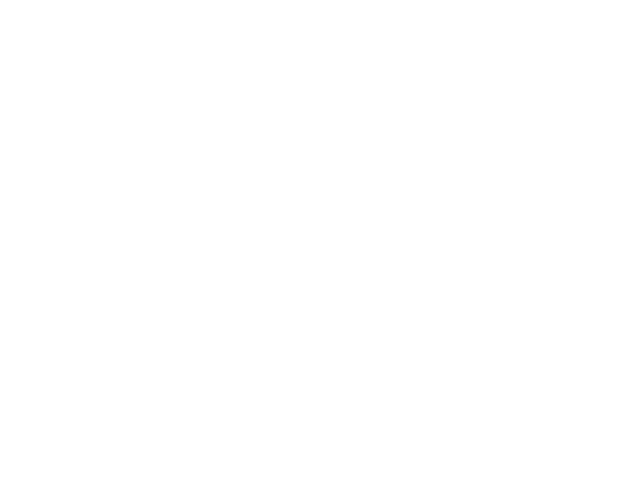

In [24]:
plt.figure();
plt.plot(regressors[:, :30]);

In [32]:

dm = DesignMatrix(regressors, name='regressors')

<IPython.core.display.Javascript object>


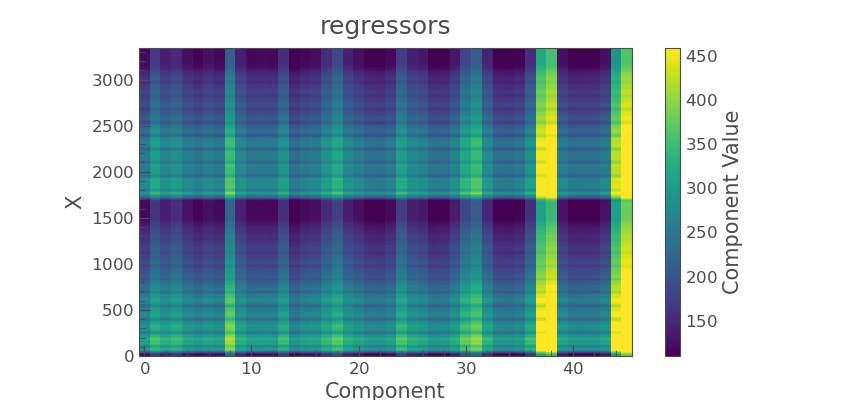

<AxesSubplot:title={'center':'regressors'}, xlabel='Component', ylabel='X'>

In [33]:
dm.plot()

In [34]:
dm = dm.pca()

<IPython.core.display.Javascript object>


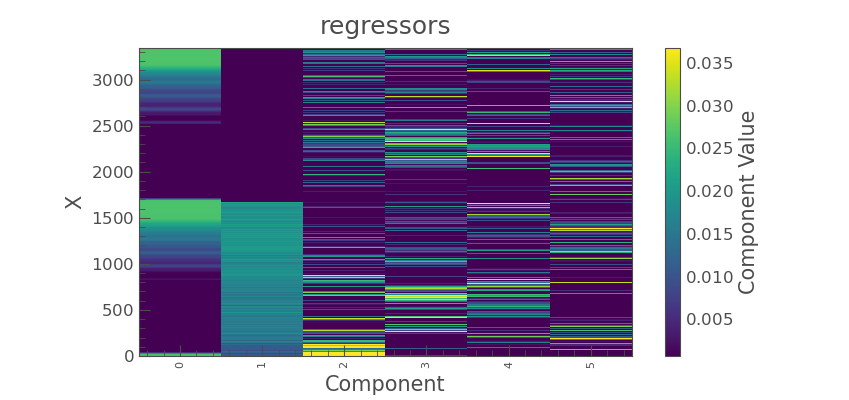

<AxesSubplot:title={'center':'regressors'}, xlabel='Component', ylabel='X'>

In [35]:
# dm = dm.append_constant();
dm.plot()

<IPython.core.display.Javascript object>


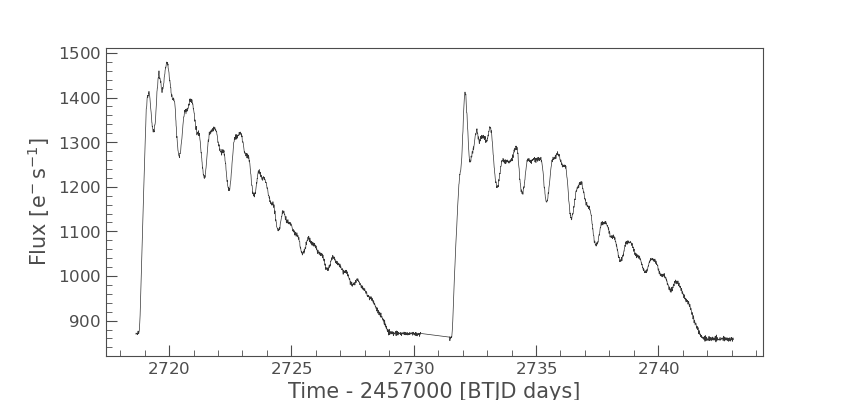

In [36]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot();

In [37]:
corrector = lk.RegressionCorrector(uncorrected_lc)
corrected_lc = corrector.correct(dm)

<IPython.core.display.Javascript object>


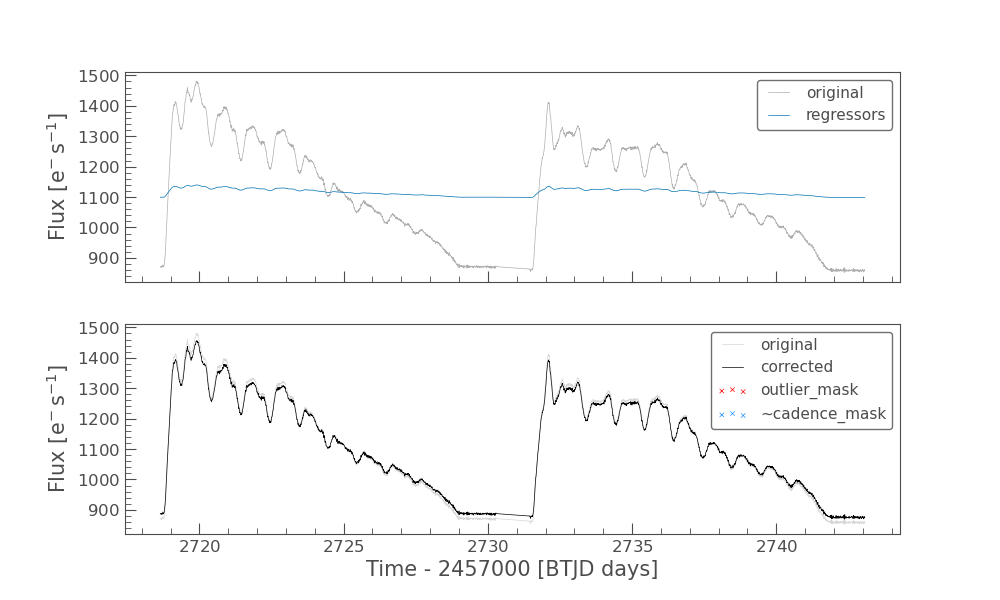

In [38]:
corrector.diagnose();

<IPython.core.display.Javascript object>


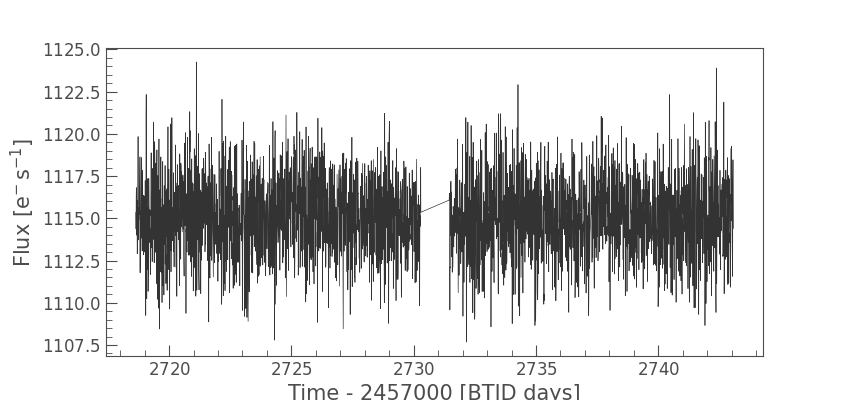

In [239]:
corrected_lc.plot();

<IPython.core.display.Javascript object>


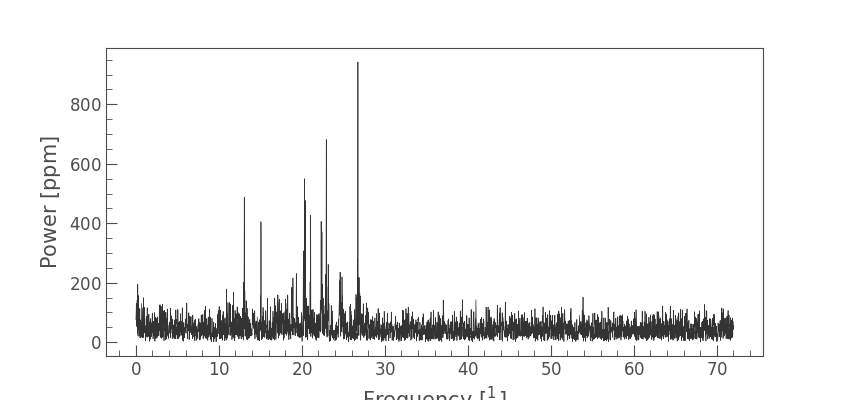

<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{ppm}$]'>

In [240]:
pg = corrected_lc.normalize(unit='ppm').to_periodogram()
pg.plot()

In [241]:
pg.period_at_max_power

<Quantity 0.03736658 d>

/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/lightcurve.py:1937: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1)


<IPython.core.display.Javascript object>


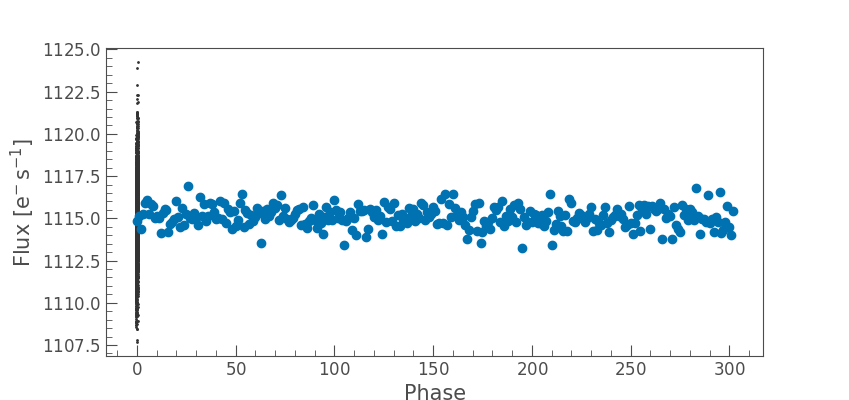

In [271]:
fc = corrected_lc.fold(pg.period_at_max_power, normalize_phase=True);
fc.scatter();

In [272]:
corrected_lc_pd = fc.to_pandas()

In [273]:
corrected_lc_pd.head()

,flux,flux_err,time_original,centroid_col,centroid_row,cadenceno,quality
time,,,,,,,
-0.499898,1113.287729,1.460176,2022-05-30 16:01:28.841333763,1479.761884,963.275927,1654,0
-0.499235,1116.353958,1.619726,2022-06-01 05:41:26.848359508,1479.741083,963.278637,1714,0
-0.498848,1114.165078,1.773286,2022-06-02 00:31:26.027489722,1479.727531,963.287503,1827,0
-0.498426,1116.247103,1.718247,2022-06-02 19:21:25.321505574,1479.732073,963.284199,1940,0
-0.497982,1114.586409,1.745043,2022-06-03 14:11:24.687880603,1479.729540,963.284672,2053,0


In [298]:
len(corrected_lc_pd.flux.values[:3330])

3330

In [305]:
means = np.mean(np.split(corrected_lc_pd.flux.values[:3330], 111), axis=0)
means.shape

(30,)

In [306]:
len(means)

30

<IPython.core.display.Javascript object>


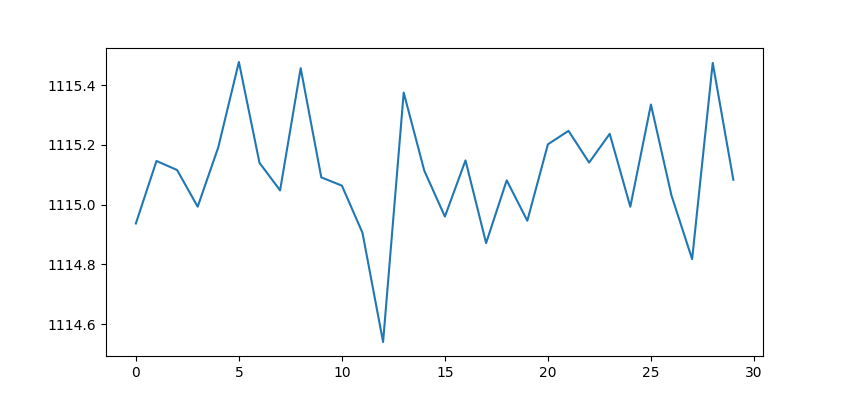

In [308]:
plt.figure();
plt.plot(np.arange(30), means)

In [263]:
corrected_lc

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
Time,float64,float64,float64,float64,int64,int32
2718.640099657997,1115.3447062054734,1.4601759940374421,1479.7582919204233,963.2731320825654,0,0
2718.6470439411455,1114.3739027696492,1.4620327031800098,1479.75840211837,963.2731997437954,1,0
2718.653988224295,1116.3128469911233,1.4614644451743146,1479.7582276777025,963.2735079431654,2,0
2718.6609325076774,1116.8190422372409,1.4614590616512138,1479.7578736430062,963.2719009213071,3,0
2718.6678767912936,1114.0073765929915,1.4603181229819235,1479.75673621264,963.2720869192574,4,0
2718.674821075141,1114.3166894558449,1.460973239400331,1479.7581646725425,963.2756169041278,5,0
...,...,...,...,...,...,...
2743.0356508771147,1111.5630975432423,1.4478397028751344,1479.7585178217232,963.2626761463915,3337,0


In [18]:
lc_result = lk.search_lightcurve('TIC 461601177', mission='TESS')

TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]
TypeError('The value must be a valid Python or Numpy numeric type.') [astropy.table.table]


<IPython.core.display.Javascript object>


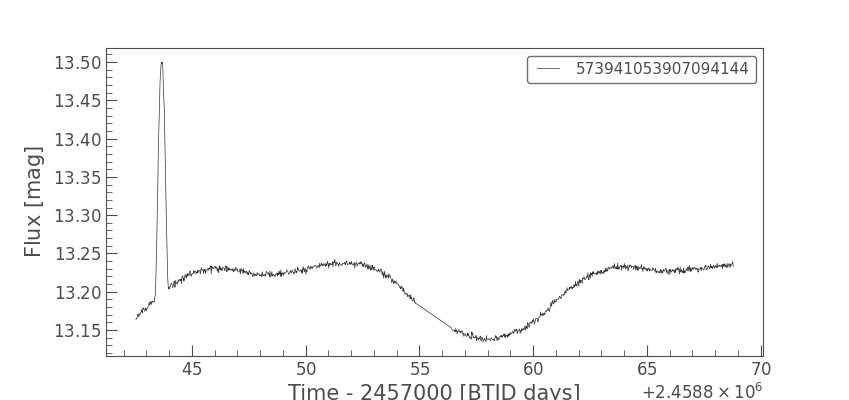

In [22]:
lc_result[4].download().plot();

In [2]:
def download_lc(tic: int, cutout_size: int = 10) -> List[lk.LightCurve]:
    ts = lk.search_tesscut(f'TIC {int(tic)}')
    print(f'Downloaded {len(ts)} tesscuts.')
    
    _, ax = plt.subplots(ncols=3, nrows=len(ts))
    
    light_curves: List[lk.lightcurve] = []
    
    for i, cut in enumerate(ts):
        try:
            tpfs = cut.download(cutout_size=cutout_size)

            aper = tpfs.create_threshold_mask()
            regressors = tpfs.flux[:, ~aper]
            dm = DesignMatrix(regressors, name='regressors')
            uncorrected_lc = tpfs.to_lightcurve(aperture_mask=aper)
            uncorrected_lc.plot(ax=ax[i, 1]);

            corrector = lk.RegressionCorrector(uncorrected_lc)
            corrected_lc = corrector.correct(dm)
            corrected_lc.plot(ax=ax[i, 2])

            tpfs.plot(ax[i, 0], aperture_mask=aper)
            ax[i, 0].set_title('')
            light_curves.append(corrected_lc)
        except:
            ax[i, 0].set_visible(False);
            ax[i, 1].set_visible(False);
            ax[i, 2].set_visible(False);
            continue
    plt.show();
    
    return light_curves 

Downloaded 8 tesscuts.


/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (25) compared to the number of columns (94), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  warnings.warn(
/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (39) compared to the number of columns (96), which suggests that the matrix contains duplicate or correlated columns. This may prevent the regression from succeeding. Consider reducing the dimensionality by calling the `pca()` method.
  warnings.warn(
/home/mjablons/.local/lib/python3.9/site-packages/lightkurve/correctors/designmatrix.py:307: LightkurveWarning: The design matrix has low rank (27) compared to the number of columns (94), which suggests that th

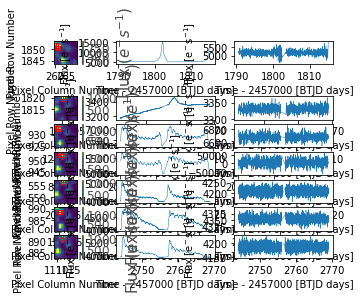

In [4]:
lcs = download_lc(461601177)

In [8]:
with open('test.dat', 'rb') as f:
    lcs = pickle.load(f)

In [9]:
lcs

[<TessLightCurve length=1103 LABEL="" SECTOR=18>
        time               flux             flux_err         centroid_col       centroid_row    cadenceno quality
                       electron / s       electron / s           pix                pix                          
        Time             float64            float64            float64            float64         int64    int32 
 ------------------ ------------------ ------------------ ------------------ ------------------ --------- -------
  1790.679047041966  5194.419096410756 2.2658028368378313  261.1642198342356 1851.0069178203385         0       0
 1790.6998807175037  5150.199870305335 2.2646105369564626  261.1643312063988 1851.0055859192498         1       0
 1790.7207143921087  5275.347539574445 2.2656762479050365 261.16393667895613 1851.0072135334733         2       0
 1790.7415480656668  5157.942046709596  2.266481855749436 261.16377270664725 1851.0074615032502         3       0
 1790.7623817384106  5114.346611500585 